# Case-study: use of PIC-SURE API to extract data from the COPD cohort

## INTRO - Install the required libraries

We install the newly created package picsuRe to facilitate the use of the PIC-SURE API

We also set up the JupyterNB environment

In [1]:
library(devtools)

install_github("hms-dbmi/picsuRe", force = TRUE)
library(picsuRe)

from URL https://api.github.com/repos/hms-dbmi/picsuRe/zipball/master
Installing picsuRe
'/opt/conda/lib/R/bin/R' --no-site-file --no-environ --no-save --no-restore  \
  --quiet CMD INSTALL  \
  '/tmp/Rtmp6N7DeP/devtools108d4f3ab7f7/hms-dbmi-picsuRe-cfdda08'  \
  --library='/opt/conda/lib/R/library' --install-tests 



In [2]:
httr::set_config(httr::config(ssl_verifypeer = 0L, ssl_verifyhost = 0L, ssl_verifystatus  = 0L))
if (!file.exists(Sys.getenv("TAR")))  Sys.setenv(TAR = "/bin/tar")

install_github("kaz-yos/tableone", force = TRUE)
library(tableone)
    
install.packages("reticulate", repos = "http://cran.r-project.org")
library(reticulate)

from URL https://api.github.com/repos/kaz-yos/tableone/zipball/master
Installing tableone
'/opt/conda/lib/R/bin/R' --no-site-file --no-environ --no-save --no-restore  \
  --quiet CMD INSTALL  \
  '/tmp/Rtmp6N7DeP/devtools108db1b8c25/kaz-yos-tableone-48edcec'  \
  --library='/opt/conda/lib/R/library' --install-tests 

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


## 1. Data extraction
`environment`: The URL of the environment

`key`: To authenticate with PIC-SURE put your key or token in an otherwise empty text file in your JupyterNotebook's top level folder. The key will be read from there so the key does not get seen by anyone except you.

`variables`: A vector with the variables of interest. You can put a variable, or a path, as you want. You can also use the * key if you want to use a wild card. If an argument corresponds to a node, it will return all the variables below the node

In [25]:
env <- "https://copdgene.hms.harvard.edu"
key <- as.character(read.table("key.csv", sep=",")[1,1])

var1 <- "00 Affection status"
var2 <- "00 Consent groups"
var3 <- "01 Demographics/01 Demographics/Gender"
var4 <- "01 Demographics/Age at enrollment"
var5 <- "01 Demographics/01 Demographics/Race"
var6 <- "03 Clinical data/Respiratory disease form/05 Environmental exposures/01 Cigarette smoking/02 Do you now smoke cigarettes as of one month ago"
var7 <- "Oxygen saturation and therapy/05 Resting SaO2 in percent"


var <- c(var1, var2, var3, var4, var5, var6, var7)

With the function `picsure`, we build our query, and get the results back from the API. The output is a dataset with the variables of interests. By default, it will return all the patients that have at least one value for a variable.

In [4]:
system.time(
demo <- picsure(env, key, var, verbose = TRUE)
)

Hi samlp|Laura_Versmee thank you for using picsuRe!

Retrieving the selected pathways:
  Using the "find" function of PICSURE

Retrieving all variables associated with: /00 Affection status
/i2b2-wildfly-default/Demo/00 Affection status/00 Affection status/Case/
/i2b2-wildfly-default/Demo/00 Affection status/00 Affection status/Control/
/i2b2-wildfly-default/Demo/00 Affection status/00 Affection status/Exclusionary Disease/
/i2b2-wildfly-default/Demo/00 Affection status/00 Affection status/Other/

Retrieving all variables associated with: /00 Consent groups
/i2b2-wildfly-default/Demo/00 Consent groups/00 Consent groups/DS-LD/
/i2b2-wildfly-default/Demo/00 Consent groups/00 Consent groups/HMB/

Retrieving all variables associated with: /01 Demographics/01 Demographics/Gender
/i2b2-wildfly-default/Demo/01 Demographics/01 Demographics/Gender/Female/
/i2b2-wildfly-default/Demo/01 Demographics/01 Demographics/Gender/Male/

Retrieving all variables associated with: /01 Demographics/Age at en

   user  system elapsed 
 24.124   0.354 434.847 

In [6]:
names(demo)[2]<-"Affection_status"
names(demo)[3]<-"Consent_groups"
names(demo)[7]<-"Do_you_now_smoke_cigarettes"
names(demo)[8]<-"Resting_SaO2_in_percent"

## 2. Use the data to make statistics
### 2.a. Summary statistics
Let's take a look at the characteristics of our population

In [8]:
catVars <- c("Consent_groups", "Gender", "Affection_status", "Race", "Do_you_now_smoke_cigarettes")
vars <- c("Consent_groups", "Affection_status", "Race", "Do_you_now_smoke_cigarettes", "Age_at_enrollment", "Resting_SaO2_in_percent")

paste("We have", nrow(demo), "patients in our population.")
"Table 1: Description of the population from the COPD Study"
CreateTableOne(vars, data = demo[,-1], factorVars = catVars, strata = c("Gender"), test = FALSE)

[1] "We have 10371 patients in our population."

[1] "Table 1: Description of the population from the COPD Study"

                                       Stratified by Gender
                                        Female        Male         
  n                                      4847          5524        
  Consent_groups = HMB (%)               4725 (97.5)   5374 (97.3) 
  Affection_status (%)                                             
     Case                                1639 (33.8)   2053 (37.2) 
     Control                             2144 (44.2)   2355 (42.6) 
     Exclusionary Disease                  27 ( 0.6)     37 ( 0.7) 
     Other                               1037 (21.4)   1079 (19.5) 
  Race = Caucasian (%)                   3303 (68.1)   3630 (65.7) 
  Do_you_now_smoke_cigarettes = Yes (%)  2424 (50.0)   3013 (54.5) 
  Age_at_enrollment (mean (sd))         59.55 (9.04)  59.60 (9.05) 
  Resting_SaO2_in_percent (mean (sd))   96.15 (3.08)  96.08 (2.85) 

### 2.b. Comparison of a categorical variable with a continuous one. 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.90   52.00   58.80   59.58   66.50   85.00 

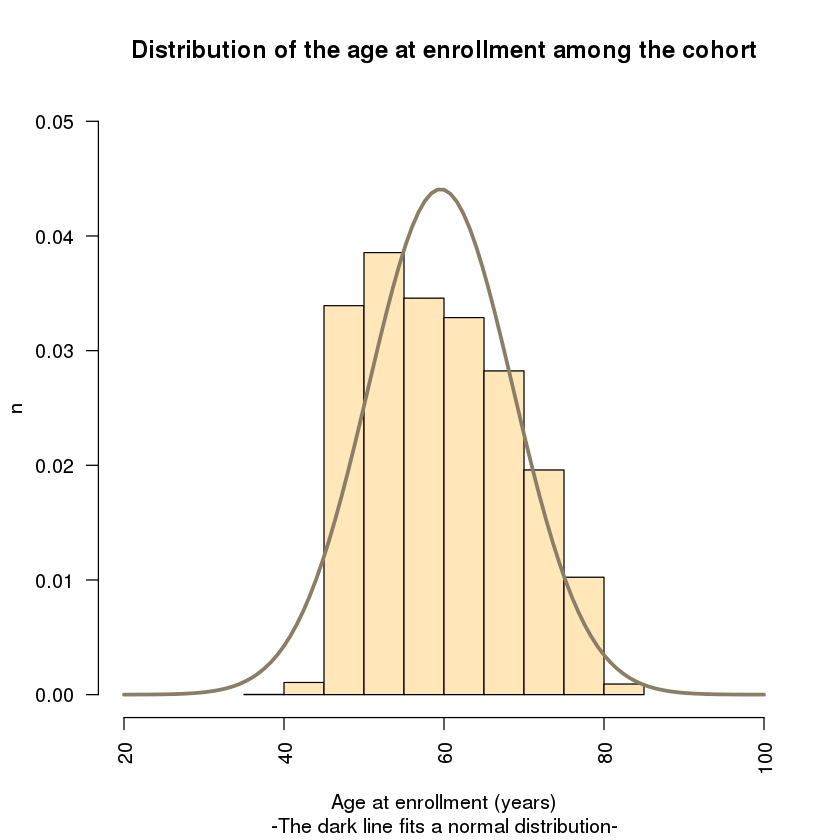

In [9]:
Age <- demo$Age_at_enrollment
summary(Age)
hist(Age,
     main="Distribution of the age at enrollment among the cohort",
     sub="-The dark line fits a normal distribution-",
     xlab="Age at enrollment (years)", 
     ylab="n",
     border="black", 
     col="wheat1",
     xlim=c(20,100),
     ylim=c(0,0.05),
     breaks=10,
     las = 2,
     prob = TRUE
    )
m <- mean(Age, na.rm = TRUE)
std <- sqrt(var(Age, na.rm = TRUE))
x <- length(Age)
curve(dnorm(x, mean=m, sd=std), col="wheat4", lwd=3, add=TRUE, yaxt="n")

### 2.c. Comparison of 2 categorical variables. Cases and smokers.

In [10]:
demo <- demo[((demo$Affection_status == "Case" | demo$Affection_status == "Control")
            & (demo$Do_you_now_smoke_cigarettes == "Yes" | demo$Do_you_now_smoke_cigarettes == "No")),]
demo <- droplevels(demo)

Smokers <- demo$Do_you_now_smoke_cigarettes
Cases <- demo$Affection_status

table(Cases, Smokers)
chisq.test(Cases, Smokers)

         Smokers
Cases       No  Yes
  Case    2191 1501
  Control 1878 2621


	Pearson's Chi-squared test with Yates' continuity correction

data:  Cases and Smokers
X-squared = 250.62, df = 1, p-value < 2.2e-16


### 3.b. Statistical analysis
We can now run a t-test in order to compare the resting SaO2 between case and control

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  73.00   95.00   97.00   96.01   98.00   99.00       2 


	Welch Two Sample t-test

data:  Resting_SaO2_in_percent by Affection_status
t = -36.38, df = 5536.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.525532 -2.267266
sample estimates:
   mean in group Case mean in group Control 
             94.69295              97.08935 


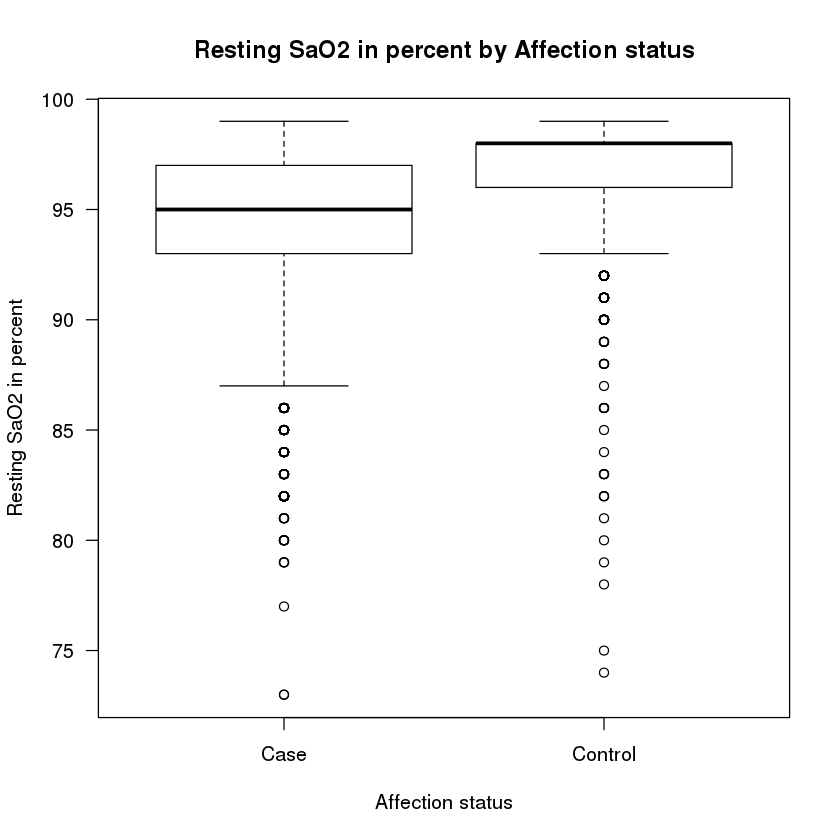

In [11]:
demo2 <- demo[(demo$Affection_status == "Case" | demo$Affection_status == "Control"),]

Resting_SaO2_in_percent <- demo$Resting_SaO2_in_percent
Affection_status <- demo2$Affection_status

summary(Resting_SaO2_in_percent)
t.test(Resting_SaO2_in_percent~Affection_status)
boxplot(Resting_SaO2_in_percent~Affection_status, main="Resting SaO2 in percent by Affection status", xlab="Affection status", ylab="Resting SaO2 in percent",   las = 1)